# Tesla Stock Prediction Using LSTM

# Importing Libraries

In [50]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Reading The Data

In [51]:
data_dir = '/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv'
df = pd.read_csv(data_dir, parse_dates= True , index_col= "Date")

# Data Exploration

In [52]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2956 non-null   float64
 1   High       2956 non-null   float64
 2   Low        2956 non-null   float64
 3   Close      2956 non-null   float64
 4   Adj Close  2956 non-null   float64
 5   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 161.7 KB


In [54]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2956.000000,2956.000000,2956.000000,2956.000000,2956.000000,2.956000e+03
mean,138.691296,141.771603,135.425953,138.762183,138.762183,3.131449e+07
std,250.044839,255.863239,243.774157,250.123115,250.123115,2.798383e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,19.627000,20.402000,19.127500,19.615000,19.615000,1.310288e+07
50%,46.656999,47.487001,45.820002,46.545000,46.545000,2.488680e+07
75%,68.057001,69.357500,66.911501,68.103998,68.103998,3.973875e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


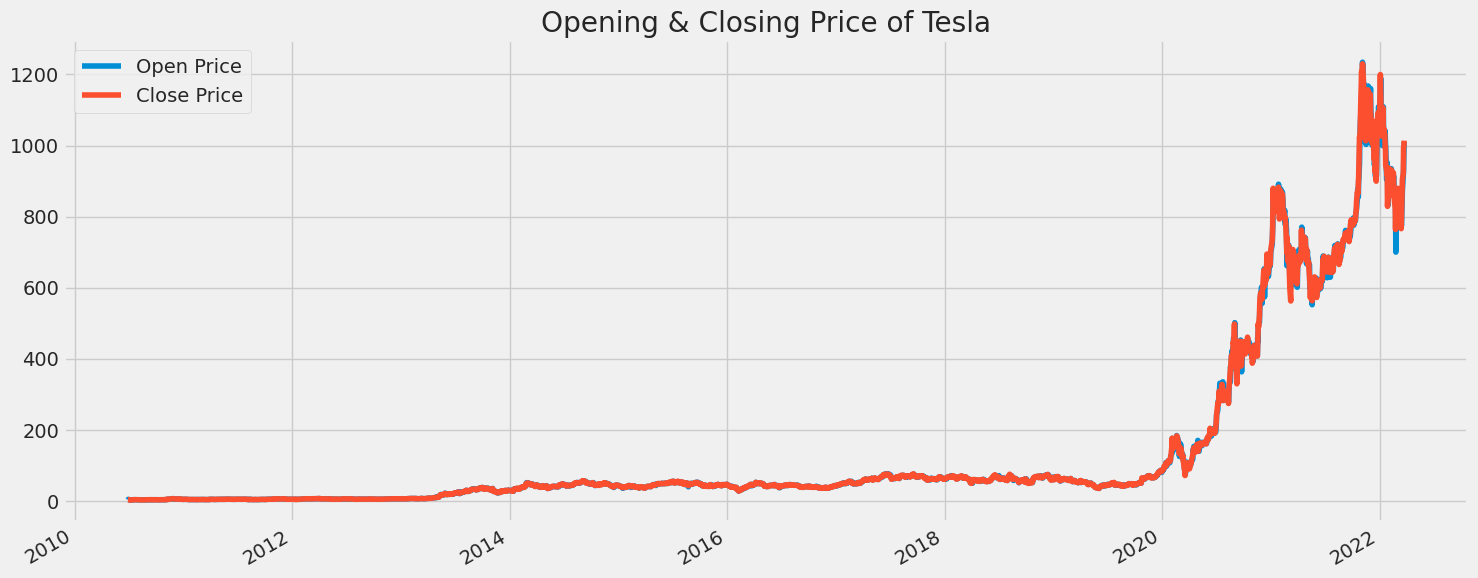

In [55]:
plt.figure(figsize=(15, 6))
df['Open'].plot()
df['Close'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Opening & Closing Price of Tesla")
plt.legend(['Open Price', 'Close Price'])
plt.tight_layout()
plt.show()

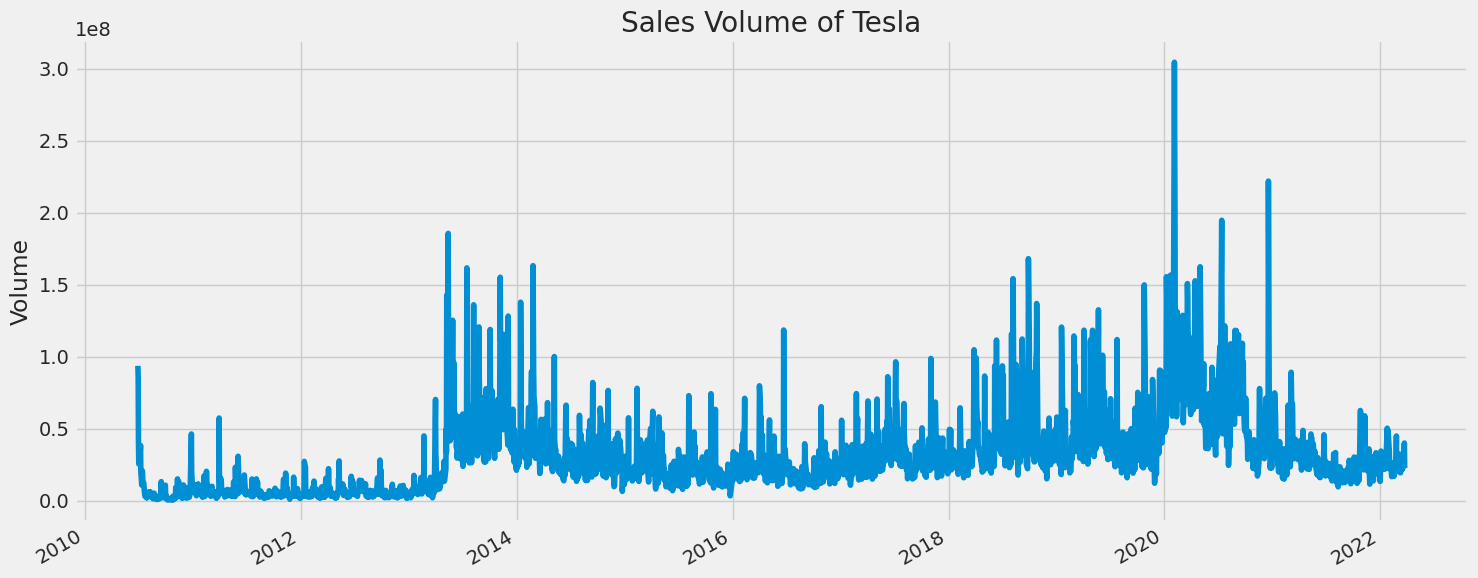

In [56]:
plt.figure(figsize=(15, 6))
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title("Sales Volume of Tesla")
plt.tight_layout()
plt.show()

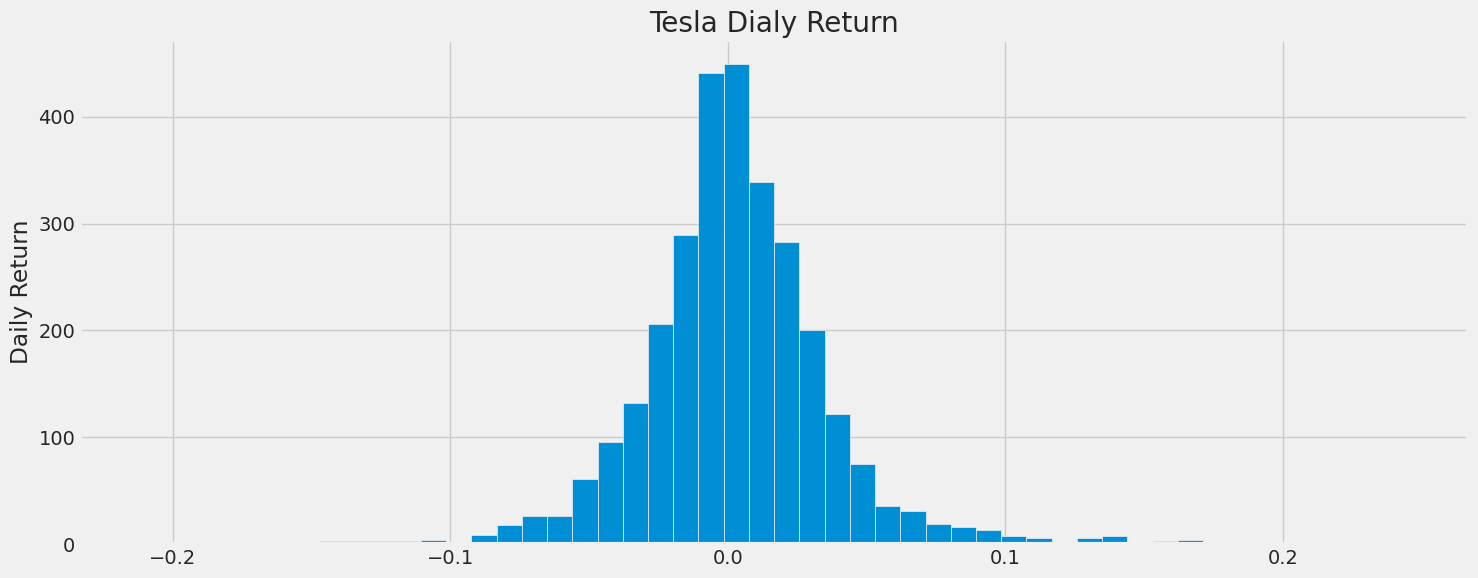

In [57]:
# use pct_change to find the percent change for each day
plt.figure(figsize=(15, 6))
df['Adj Close'].pct_change().hist(bins=50)
plt.ylabel('Daily Return')
plt.title(f'Tesla Dialy Return')
plt.tight_layout()
plt.show()

# Data Preprocessing

In [58]:
dataset = df["Close"]
dataset = pd.DataFrame(dataset)

data = dataset.values

data.shape

(2956, 1)

In [59]:
#Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

In [60]:
#splitting the data
# 75% to Train , 25% to Test
train_size = int(len(data)*.75)
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = scaled_data[ :train_size , 0:1 ]
test_data = scaled_data[ train_size-60: , 0:1 ]

Train Size : 2217 Test Size : 739


In [61]:
train_data.shape, test_data.shape

((2217, 1), (799, 1))

In [62]:
#create the train set
# Creating a Training set with 60 time-steps and 1 output
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [63]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [64]:
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [65]:
x_train.shape , y_train.shape

((2157, 60, 1), (2157,))

# LSTM model

In [66]:
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], 1)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= "mean_absolute_error")

In [67]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 64)                29440     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 42,465
Trainable params: 42,465
Non-trainable params: 0
_________________________________________________________________


In [68]:
# model training
# Fitting the LSTM to the Training set
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100
68/68 [==============================] - 8s 62ms/step - loss: 1.0878e-04 - mean_absolute_error: 0.0068
Epoch 2/100
68/68 [==============================] - 4s 61ms/step - loss: 5.0886e-06 - mean_absolute_error: 0.0016
Epoch 3/100
68/68 [==============================] - 4s 61ms/step - loss: 5.4485e-06 - mean_absolute_error: 0.0017
Epoch 4/100
68/68 [==============================] - 4s 61ms/step - loss: 5.4995e-06 - mean_absolute_error: 0.0018
Epoch 5/100
68/68 [==============================] - 4s 62ms/step - loss: 5.0046e-06 - mean_absolute_error: 0.0016
Epoch 6/100
68/68 [==============================] - 4s 61ms/step - loss: 4.3852e-06 - mean_absolute_error: 0.0015
Epoch 7/100
68/68 [==============================] - 4s 63ms/step - loss: 4.3106e-06 - mean_absolute_error: 0.0015
Epoch 8/100
68/68 [==============================] - 4s 65ms/step - loss: 6.0031e-06 - mean_absolute_error: 0.0019
Epoch 9/100
68/68 [==============================] - 4s 61ms/step - loss: 4.5079

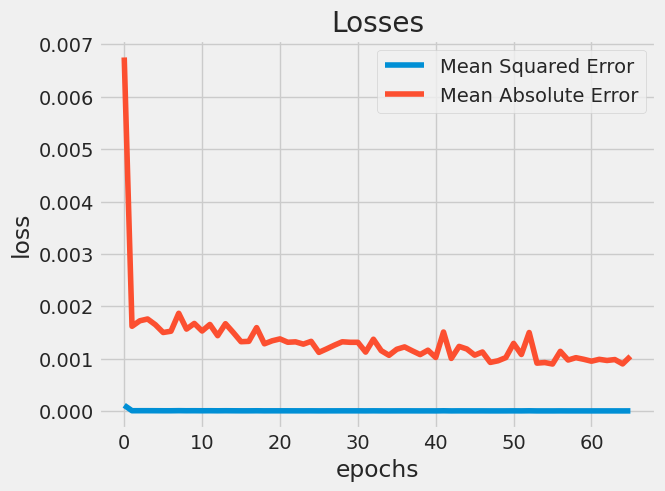

In [69]:
#Evaluation
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Prediction

In [70]:
# creating test set
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [71]:
x_test.shape , y_test.shape

((739, 60, 1), (739,))

In [72]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

24/24 [==============================] - 1s 21ms/step


(739, 1)

In [73]:
#inverse y_test scaling
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

21.69

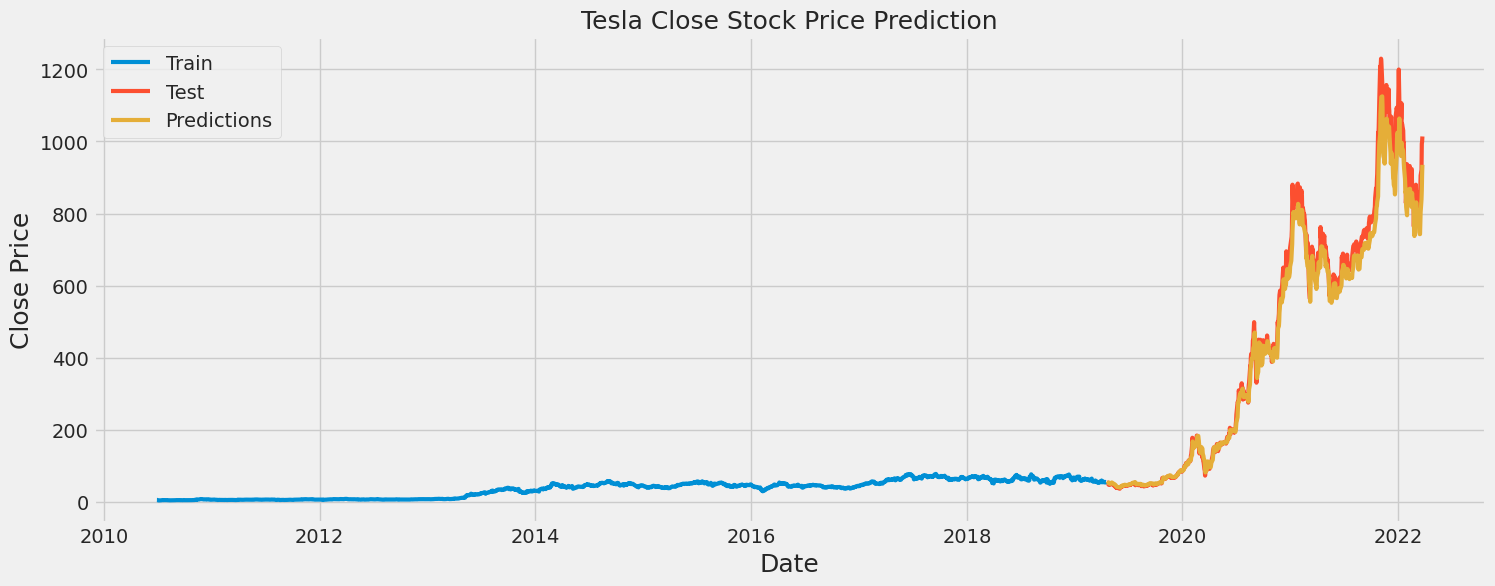

In [74]:
#visializing prediciton with the data


train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Tesla Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['Close'], linewidth= 3)
plt.plot(test['Close'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])


# Predict Next 30 Days

In [75]:
from datetime import timedelta

In [76]:
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [77]:
future = 30
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0, 0]) 
    print(forcast)
    Xin = insert_end(Xin, out[0, 0]) 
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 [==============================] - 0s 31ms/step
[0.7597157]
1/1 [==============================] - 0s 28ms/step
[0.7597157, 0.7418805]
1/1 [==============================] - 0s 32ms/step
[0.7597157, 0.7418805, 0.71350133]
1/1 [==============================] - 0s 37ms/step
[0.7597157, 0.7418805, 0.71350133, 0.68165684]
1/1 [==============================] - 0s 35ms/step
[0.7597157, 0.7418805, 0.71350133, 0.68165684, 0.6490219]
1/1 [==============================] - 0s 35ms/step
[0.7597157, 0.7418805, 0.71350133, 0.68165684, 0.6490219, 0.61720747]
1/1 [==============================] - 0s 35ms/step
[0.7597157, 0.7418805, 0.71350133, 0.68165684, 0.6490219, 0.61720747, 0.5873174]
1/1 [==============================] - 0s 33ms/step
[0.7597157, 0.7418805, 0.71350133, 0.68165684, 0.6490219, 0.61720747, 0.5873174, 0.5600554]
1/1 [==============================] - 0s 37ms/step
[0.7597157, 0.7418805, 0.71350133, 0.68165684, 0.6490219, 0.61720747, 0.5873174, 0.5600554, 0.5357803]
1/1 [======

In [78]:
time

[Timestamp('2022-03-24 00:00:00'),
 Timestamp('2022-03-25 00:00:00'),
 Timestamp('2022-03-26 00:00:00'),
 Timestamp('2022-03-27 00:00:00'),
 Timestamp('2022-03-28 00:00:00'),
 Timestamp('2022-03-29 00:00:00'),
 Timestamp('2022-03-30 00:00:00'),
 Timestamp('2022-03-31 00:00:00'),
 Timestamp('2022-04-01 00:00:00'),
 Timestamp('2022-04-02 00:00:00'),
 Timestamp('2022-04-03 00:00:00'),
 Timestamp('2022-04-04 00:00:00'),
 Timestamp('2022-04-05 00:00:00'),
 Timestamp('2022-04-06 00:00:00'),
 Timestamp('2022-04-07 00:00:00'),
 Timestamp('2022-04-08 00:00:00'),
 Timestamp('2022-04-09 00:00:00'),
 Timestamp('2022-04-10 00:00:00'),
 Timestamp('2022-04-11 00:00:00'),
 Timestamp('2022-04-12 00:00:00'),
 Timestamp('2022-04-13 00:00:00'),
 Timestamp('2022-04-14 00:00:00'),
 Timestamp('2022-04-15 00:00:00'),
 Timestamp('2022-04-16 00:00:00'),
 Timestamp('2022-04-17 00:00:00'),
 Timestamp('2022-04-18 00:00:00'),
 Timestamp('2022-04-19 00:00:00'),
 Timestamp('2022-04-20 00:00:00'),
 Timestamp('2022-04-

# Predicte dataframe

In [79]:
forcasted_output = np.asanyarray(forcast)   
forcasted_output = forcasted_output.reshape(-1, 1) 
forcasted_output = scaler.inverse_transform(forcasted_output) 

In [80]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"

# predicting price

In [81]:
df_result

,Date,Forecasted
0,2022-03-24,935.141235
1,2022-03-25,913.261902
2,2022-03-26,878.447815
3,2022-03-27,839.382568
4,2022-03-28,799.347717
5,2022-03-29,760.319336
6,2022-03-30,723.651672
7,2022-03-31,690.208008
8,2022-04-01,660.428528
9,2022-04-02,634.408691


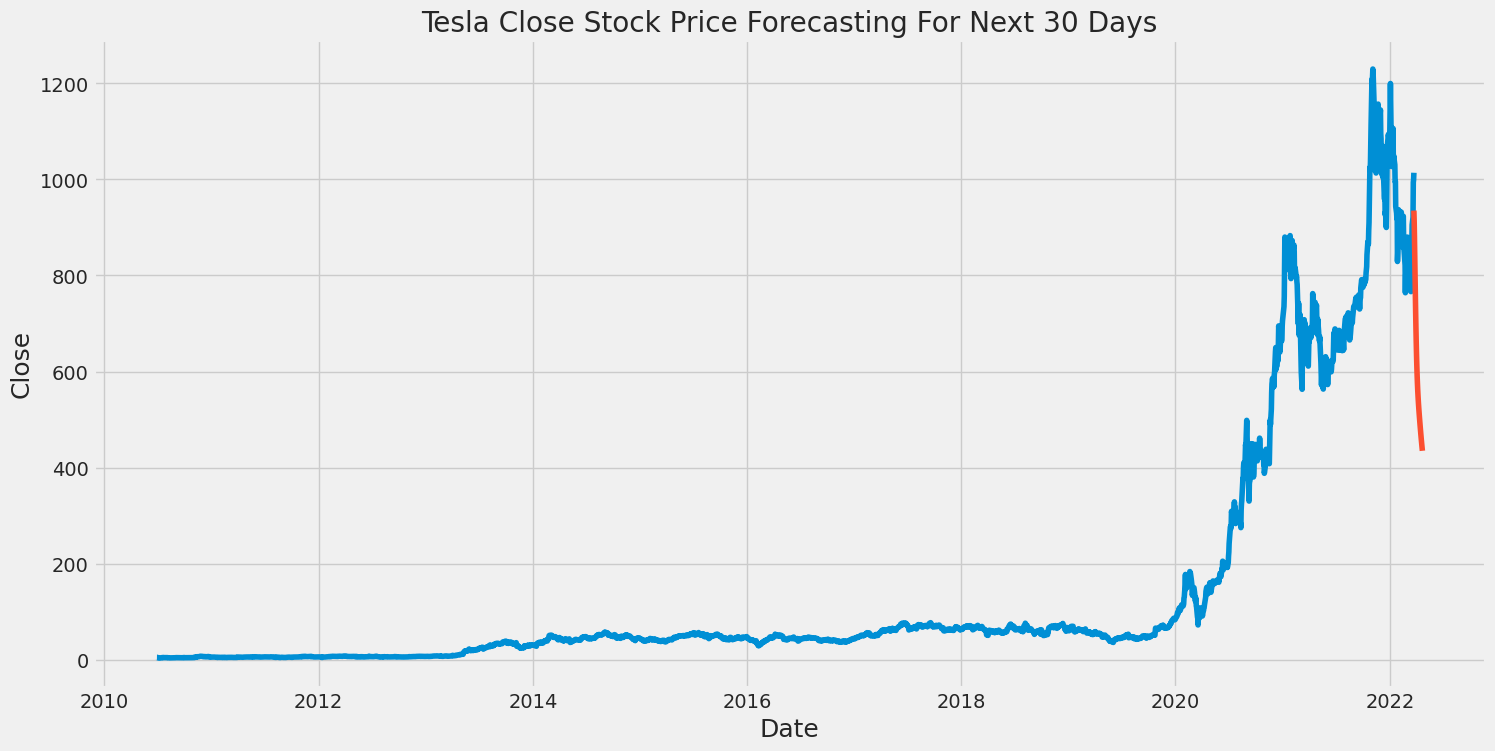

In [82]:
plt.figure(figsize=(16, 8))
plt.title('Tesla Close Stock Price Forecasting For Next 30 Days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close' ,fontsize=18)
plt.plot(df['Close'])
plt.plot(df_result.set_index('Date')[['Forecasted']])